In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [9]:
import os

base_dir = './'
train_dir = os.path.join(base_dir, '../dataset/processed')
validation_dir = os.path.join(base_dir, '../dataset/test')


In [5]:
batch_size = 4
total_train = 164
total_test = 20
img_size = (img_width, img_height) = (128, 128)
epochs = 30

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range = 0.2,
        fill_mode='nearest'
      )

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
class_mode = 'sparse'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

Found 322 images belonging to 4 classes.
Found 24 images belonging to 4 classes.


In [6]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
    return model

In [7]:
checkpoint_path = './trained_model/model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [8]:
model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(
      train_generator,
      epochs=epochs,
      steps_per_epoch=total_train//batch_size,
      validation_data=validation_generator,
      validation_steps=total_test//batch_size, 
      callbacks=[cp_callback]
      )

Epoch 1/30
41/41 [==============================] - ETA: 0s - loss: 1.4718 - accuracy: 0.3720
Epoch 1: saving model to ./trained_model\model.ckpt
41/41 [==============================] - 8s 162ms/step - loss: 1.4718 - accuracy: 0.3720 - val_loss: 1.3668 - val_accuracy: 0.4000
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 1.2406 - accuracy: 0.3395
Epoch 2: saving model to ./trained_model\model.ckpt
41/41 [==============================] - 6s 144ms/step - loss: 1.2406 - accuracy: 0.3395 - val_loss: 1.3977 - val_accuracy: 0.5000
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 1.2404 - accuracy: 0.4512
Epoch 3: saving model to ./trained_model\model.ckpt
41/41 [==============================] - 6s 150ms/step - loss: 1.2404 - accuracy: 0.4512 - val_loss: 1.3038 - val_accuracy: 0.4500
Epoch 4/30
41/41 [==============================] - ETA: 0s - loss: 1.1593 - accuracy: 0.5247
Epoch 4: saving model to ./trained_model\model.ckpt
41/41 [================

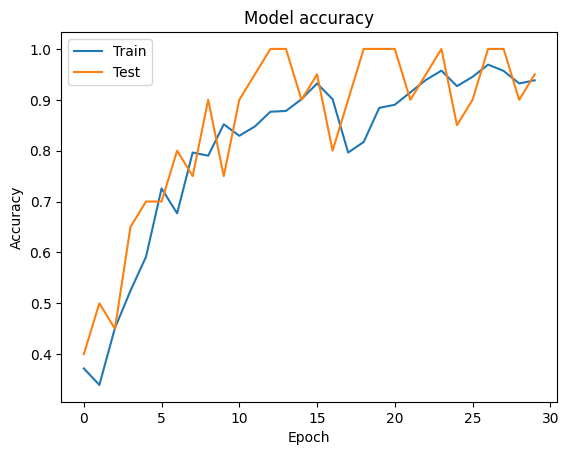

In [9]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

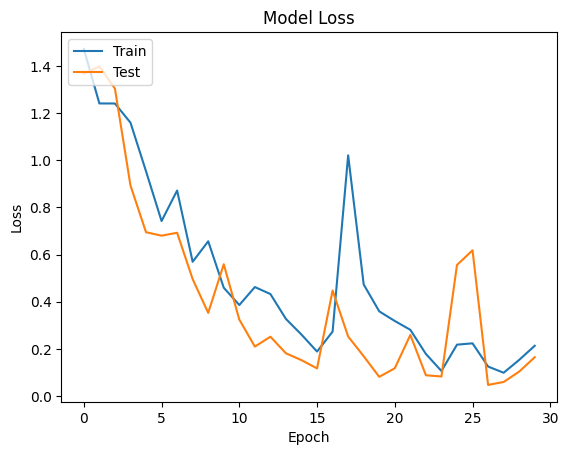

In [10]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
model.save_weights('./trained_model/weights.h5')
model.save('./trained_model/model.h5')

<h2>Load Model</h2>

In [3]:
reconstructed_model = tf.keras.models.load_model('./trained_model/model.h5')

<h2>Predicting an Image</h2>

In [11]:
from keras.utils import load_img, img_to_array

img = load_img('../dataset/processed/tanjirou/15.png', target_size=img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
class_list = os.listdir(train_dir)
prediction = reconstructed_model.predict(img)
print(prediction)
for j in range(5):
    if prediction[0][j] == 1. :
        print(class_list[j])
        break

1/1 [==============================] - 0s 131ms/step
[[5.0697317e-03 9.8838156e-01 6.5361806e-03 1.1754240e-05 6.6922848e-07]]


In [13]:
# import requests
# from io import BytesIO

# response = requests.get('https://img.okezone.com/content/2021/02/24/194/2367275/makna-mendalam-motif-batik-mega-mendung-yyHMjm5xCF.jpg')

# img = tf.keras.utils.load_img(
#     BytesIO(response.content), target_size=(img_height, img_width)
# )
# img = img_to_array(img)
img = load_img('../dataset/input_sample/1.jpg', target_size=img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

predictions = reconstructed_model.predict(img)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_list[np.argmax(score)], 100 * np.max(score))
)
print(predictions)

1/1 [==============================] - 0s 145ms/step
This image most likely belongs to inosuke with a 40.46 percent confidence.
[[1.0000000e+00 1.7279064e-09 1.6818659e-10 3.8392875e-16 2.8095644e-19]]


## K-Fold Cross Validation

In [6]:
from sklearn.model_selection import KFold
import tensorflow_datasets as tfds

num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)
dataset_dir = '../dataset/processed/'

dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  image_size=(img_height, img_width),)

# dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
dataset = tfds.as_numpy(dataset)

inputs = next(iter(dataset))[0]
targets = next(iter(dataset))[1]

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
  history = reconstructed_model.fit(
    inputs[train],
    targets[train],
    epochs=epochs,
    verbose=0
  )

  # Generate generalization metrics
  scores = reconstructed_model.evaluate(inputs[test], targets[test], verbose=0)
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  print(f'Score for fold {fold_no}: {reconstructed_model.metrics_names[0]} of {scores[0]}; {reconstructed_model.metrics_names[1]} of {scores[1]*100}%')

  # Increase fold number
  fold_no = fold_no + 1

print(f'Accuracy: {np.mean(acc_per_fold)}')
print(f'Loss: {np.mean(loss_per_fold)}')

Found 320 files belonging to 4 classes.
Score for fold 1: loss of 27.088558197021484; accuracy of 25.0%
Score for fold 2: loss of 6.75257682800293; accuracy of 75.0%
Score for fold 3: loss of 1.2958543300628662; accuracy of 66.66666865348816%
Score for fold 4: loss of 0.0; accuracy of 100.0%
Score for fold 5: loss of 0.0; accuracy of 100.0%
Score for fold 6: loss of 0.0; accuracy of 100.0%
Score for fold 7: loss of 4.37100425187964e-07; accuracy of 100.0%
Score for fold 8: loss of 0.0; accuracy of 100.0%
Score for fold 9: loss of 0.0; accuracy of 100.0%
Score for fold 10: loss of 3.973642748178463e-08; accuracy of 100.0%
Accuracy: 86.66666686534882
Loss: 3.5136989831924135
